In [1]:
%matplotlib inline
import os 
import sys
import random
import warnings

import numpy as np

import matplotlib.pyplot as plt

from skimage import filters,exposure,segmentation,color,io,img_as_float
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.future import graph
from skimage.transform import resize
from skimage.morphology import label,disk

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import *

import tensorflow as tf

from sklearn.metrics import f1_score

#seed = 42
#random.seed = seed
#np.random.seed = seed

Using TensorFlow backend.


In [2]:
IMG_HEIGHT = 400
IMG_WIDTH = 400
IMG_CHANNELS = 3

In [3]:
# Helper functions

def load_image(infilename):
    data = imread(infilename)[:,:,:IMG_CHANNELS]
    return data

def load_image_label(infilename):
    data = imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [4]:
# Loaded a set of images
root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(400, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image_label(gt_dir + files[i]) for i in range(n)]
print(files[0])


Loading 100 images
satImage_061.png
Loading 100 images
satImage_061.png


In [5]:
imgs[0].shape

(400, 400, 3)

In [6]:
# Image processing tools
def constrast_streching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

In [7]:
# Preprocess input images
n_imgs = [constrast_streching(x) for x in imgs]

In [8]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [9]:
X_c_train = np.array(n_imgs)
X_train = np.array(imgs)
Y_train = np.zeros((len(imgs), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for i in range(len(imgs)):
    mask_ = np.expand_dims(gt_imgs[i], axis=-1)
    Y_train[i] = mask_

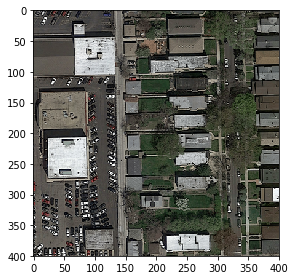

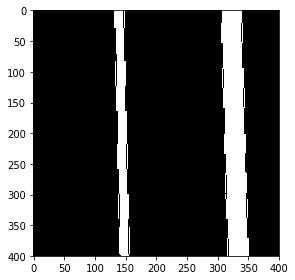

In [10]:
# Check if training data looks all right
ix = random.randint(0, len(imgs) - 1)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [11]:
print(X_train.shape)
print(Y_train.shape)
print(X_train.dtype)
print(Y_train.dtype)

(100, 400, 400, 3)
(100, 400, 400, 1)
uint8
bool


In [12]:
print(len(Y_train[Y_train == True]))

3604158


In [13]:
val_split = 0.1
idx_x = int(X_train.shape[0]*(1.0-val_split))
idx_y = int(Y_train.shape[0]*(1.0-val_split))
X_TR  = X_train[:idx_x]
Y_TR  = Y_train[:idx_y]
X_VAL = X_train[idx_x:]
Y_VAL = Y_train[idx_y:]

In [14]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

reg = 0 #1e-5

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (s)
c1 = Dropout(0.2) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (p1)
c2 = Dropout(0.2) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (p2)
c3 = Dropout(0.3) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (p3)
c4 = Dropout(0.3) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (p4)
c5 = Dropout(0.4) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (u6)
c6 = Dropout(0.3) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c6)

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (u7)
c7 = Dropout(0.3) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c7)

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (u8)
c8 = Dropout(0.2) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (u9)
c9 = Dropout(0.2) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 400, 400, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 400, 32) 896         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 400, 400, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [15]:
model_file_name = 'unet-od-cs.h5'

In [16]:
# Fit model with constrasted images
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(model_file_name, verbose=1, save_best_only=True)

# Train on constrast images
results = model.fit(X_c_train, Y_train, validation_split=0.1, batch_size=2, epochs=50, 
                    callbacks=[earlystopper, checkpointer])
# Train on normal images
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=2, epochs=50, 
                    callbacks=[earlystopper, checkpointer])


Train on 90 samples, validate on 10 samples
Epoch 1/50
90/90 [==============================] - 21s 228ms/step - loss: 0.5703 - acc: 0.7473 - val_loss: 0.5735 - val_acc: 0.7604

Epoch 00001: val_loss improved from inf to 0.57354, saving model to unet-od-cs.h5
Epoch 2/50
90/90 [==============================] - 13s 146ms/step - loss: 0.5284 - acc: 0.7761 - val_loss: 0.5748 - val_acc: 0.7604

Epoch 00002: val_loss did not improve from 0.57354
Epoch 3/50
90/90 [==============================] - 13s 146ms/step - loss: 0.5155 - acc: 0.7761 - val_loss: 0.5634 - val_acc: 0.7604

Epoch 00003: val_loss improved from 0.57354 to 0.56339, saving model to unet-od-cs.h5
Epoch 4/50
90/90 [==============================] - 13s 147ms/step - loss: 0.4971 - acc: 0.7761 - val_loss: 0.5595 - val_acc: 0.7604

Epoch 00004: val_loss improved from 0.56339 to 0.55947, saving model to unet-od-cs.h5
Epoch 5/50
90/90 [==============================] - 13s 148ms/step - loss: 0.4951 - acc: 0.7762 - val_loss: 0.5427 

Epoch 41/50
90/90 [==============================] - 13s 148ms/step - loss: 0.0892 - acc: 0.9623 - val_loss: 0.1902 - val_acc: 0.9247

Epoch 00041: val_loss did not improve from 0.15721
Epoch 42/50
90/90 [==============================] - 13s 146ms/step - loss: 0.0872 - acc: 0.9630 - val_loss: 0.1617 - val_acc: 0.9367

Epoch 00042: val_loss did not improve from 0.15721
Epoch 43/50
90/90 [==============================] - 13s 148ms/step - loss: 0.0835 - acc: 0.9642 - val_loss: 0.1681 - val_acc: 0.9355

Epoch 00043: val_loss did not improve from 0.15721
Epoch 44/50
90/90 [==============================] - 13s 146ms/step - loss: 0.0819 - acc: 0.9650 - val_loss: 0.1742 - val_acc: 0.9358

Epoch 00044: val_loss did not improve from 0.15721
Epoch 45/50
90/90 [==============================] - 13s 147ms/step - loss: 0.0797 - acc: 0.9657 - val_loss: 0.1647 - val_acc: 0.9348

Epoch 00045: val_loss did not improve from 0.15721
Epoch 46/50
90/90 [==============================] - 13s 148ms/step - 

In [19]:

# Predict on train, val and test
#model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
model = load_model(model_file_name)
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
#preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

10/10 [==============================] - 3s 302ms/step


In [20]:
preds_train_t[0]

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

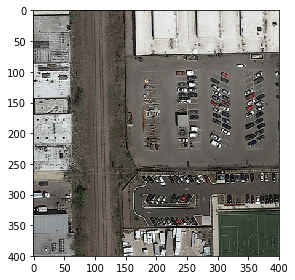

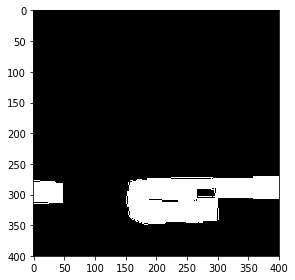

/home/hellgheast/miniconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


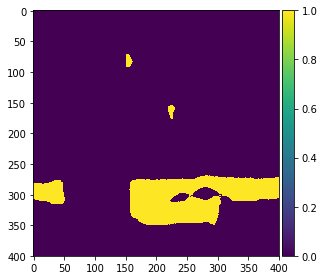

In [21]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

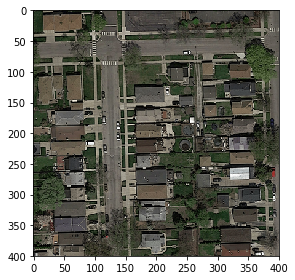

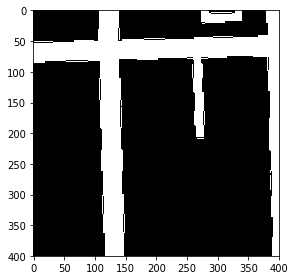

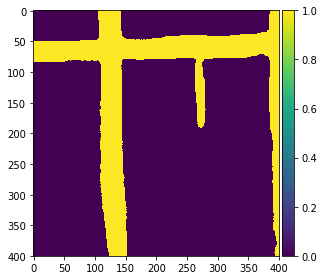

In [22]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


In [23]:
print(preds_train_t.shape)
print()
print(f1_score(preds_val_t.flatten(), Y_train[int(Y_train.shape[0]*0.9):].flatten(), average="binary"))

(90, 400, 400, 1)

0.8722072002421997
